## Oxford-IIIT Pet Dataset 을 이용하여 localization 학습하기

이 실습에서는 미리 저장된 tfrecord file을 읽어와서 개의 머리 부분을 localization하는 network을 학습시켜 봅니다.

### 이 실습 file부터 진행하는 경우 준비사항
8_0과 8_1을 건너뛰고 이번 file부터 실습을 하는 경우 아래 경로에서 tfrecord file을 다운 받은 후,  
train tfrecord file:  https://drive.google.com/file/d/12a3_RC0AO6cRsvfzYU1jYyAI-Mzb_b6r/view?usp=sharing  
validation tfrecord file: https://drive.google.com/file/d/1fvlMA_JW1BwwP2GR6CCwVorn9oNMx6et/view?usp=sharing  

실습 directory에 dogs_tfr 이라는 이름의 directory를 생성하고 위에서 download 받은 file을 upload 해야 실습이 진행 가능합니다

    
  
 

In [9]:
## library import
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from matplotlib.patches import Rectangle

print(tf.__version__)
print(keras.__version__)

2.0.0-beta1
2.2.4-tf


In [0]:
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [4]:
cd '/content/gdrive/My Drive/TensorFlow_Training_13th'

/content/gdrive/My Drive/TensorFlow_Training_13th


In [0]:
## hyper parameter 설정
batch_size = 20
learning_rate = 0.0001
training_epochs = 30
img_size = 224
n_train = 2000
n_val = 498

In [0]:
## tfrecord file 경로 설정
cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'dogs_tfr')

tfr_train = 'dogs_train.tfrecord'
tfr_val = 'dogs_val.tfrecord'

tfr_train_dir = os.path.join(tfr_dir, tfr_train)
tfr_val_dir = os.path.join(tfr_dir, tfr_val)

In [0]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32),
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [img_size, img_size, 3])
    image = tf.cast(image, tf.float32)/255.
    #image = preprocess_input(image)
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    gt = tf.stack([x, y, w, h], -1)
    
    return image, gt

In [0]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=8)
train_dataset = train_dataset.shuffle(buffer_size=n_train*2).prefetch(
    buffer_size=batch_size).batch(batch_size).repeat()

In [0]:
## validation datset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=8)
val_dataset = val_dataset.prefetch(buffer_size=batch_size).batch(batch_size)

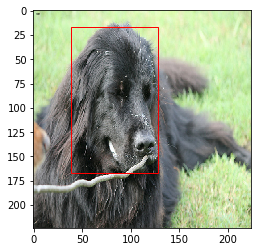

In [26]:
## train dataset에서 1개의 image와 bbox를 읽어서 확인
for image, gt in train_dataset.take(1):
    
    '''그림을 그리기 위해서 bbox의 왼쪽 위 꼭지점 좌표를 계산하고, 
    xmin, ymin, w, h 각각을 image size에 맞게 scaling'''
    x = gt[:,0]
    y = gt[:,1]
    w = gt[:,2]
    h = gt[:,3]
    xmin = x[0].numpy() - w[0].numpy()/2.
    ymin = y[0].numpy() - h[0].numpy()/2.
    rect_x = int(xmin * img_size)
    rect_y = int(ymin * img_size)
    rect_w = int(w[0].numpy() * img_size)
    rect_h = int(h[0].numpy() * img_size)
    
    ## 그림 그리기
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    plt.imshow(image[0])
    plt.show()    

In [27]:
## MobileNet V2의 pretrained model을 load
conv_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

9412608/9406464 [==============================] - 1s 0us/step


In [28]:
## localization을 위한 network
## mobilenet v2 구조에 fully connected layer 3개를 추가하고 마지막 layer는 4개의 node로 x,y,w,h를 예측하도록 함
model = models.Sequential()
model.add(conv_base)
model.add(GlobalAveragePooling2D())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dense(4, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                2

In [0]:
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=n_train//batch_size*10,
                                                          decay_rate=0.3,
                                                          staircase=True)
## optimizer는 RMSprop, loss는 mean squared error 사용
model.compile(optimizers.RMSprop(lr_schedule), loss='mse')

In [30]:
## Train!
steps_per_epoch = n_train//batch_size
validation_steps = n_val//batch_size
model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=training_epochs,
         validation_data=val_dataset,
         validation_steps=validation_steps)

Epoch 1/30
100/100 [==============================] - 72s 719ms/step - loss: 0.0424 - val_loss: 0.0337
Epoch 2/30
100/100 [==============================] - 22s 216ms/step - loss: 0.0228 - val_loss: 0.0324
Epoch 3/30
100/100 [==============================] - 21s 214ms/step - loss: 0.0128 - val_loss: 0.0227
Epoch 4/30
100/100 [==============================] - 21s 214ms/step - loss: 0.0086 - val_loss: 0.0176
Epoch 5/30
100/100 [==============================] - 21s 215ms/step - loss: 0.0068 - val_loss: 0.0145
Epoch 6/30
100/100 [==============================] - 22s 216ms/step - loss: 0.0056 - val_loss: 0.0118
Epoch 7/30
100/100 [==============================] - 21s 215ms/step - loss: 0.0047 - val_loss: 0.0106
Epoch 8/30
100/100 [==============================] - 21s 215ms/step - loss: 0.0043 - val_loss: 0.0103
Epoch 9/30
100/100 [==============================] - 21s 214ms/step - loss: 0.0041 - val_loss: 0.0085
Epoch 10/30
100/100 [==============================] - 21s 212ms/step - l

In [0]:
## validation set에 대해서 bounding box 예측
prediction = model.predict(val_dataset)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


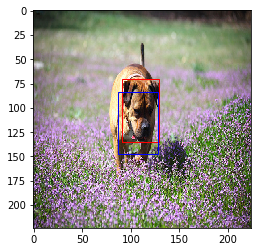

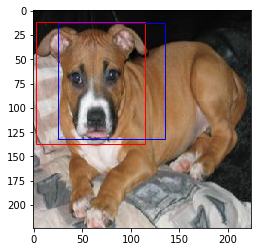

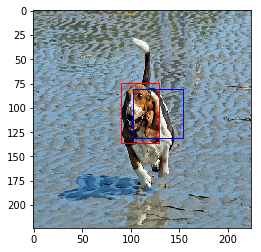

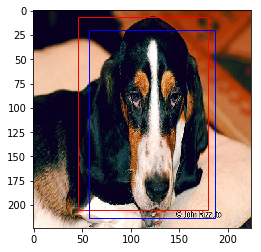

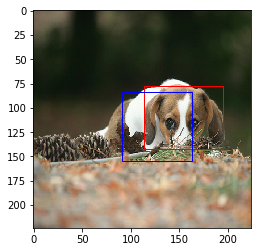

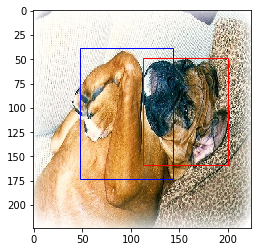

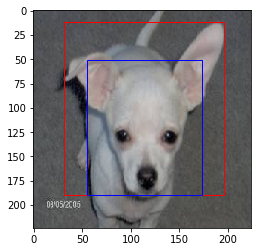

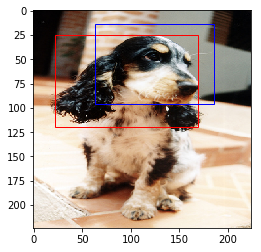

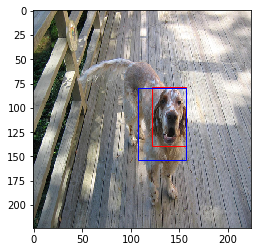

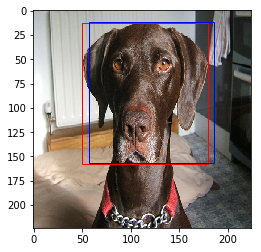

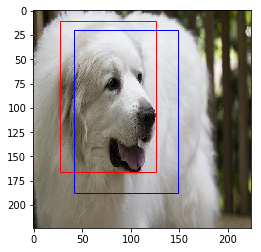

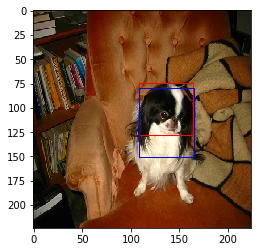

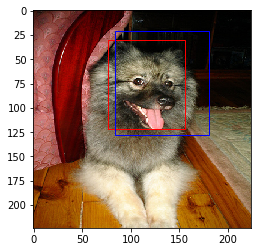

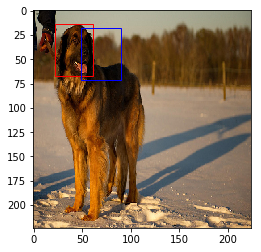

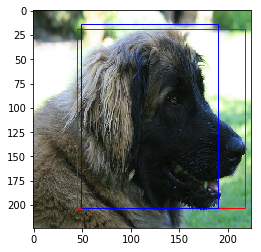

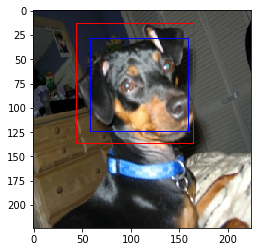

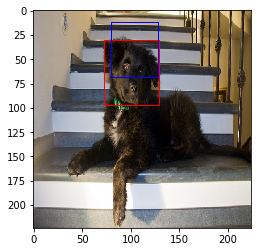

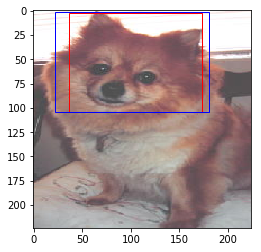

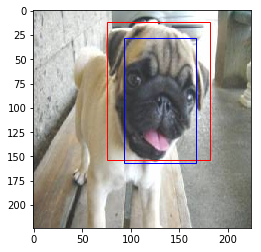

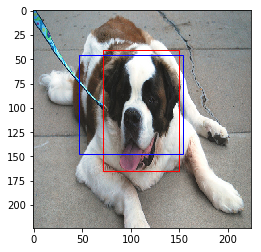

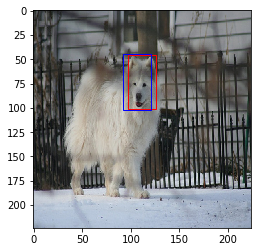

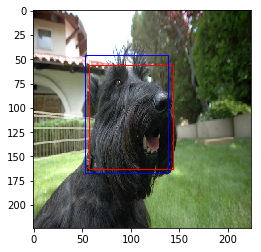

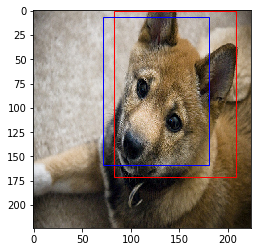

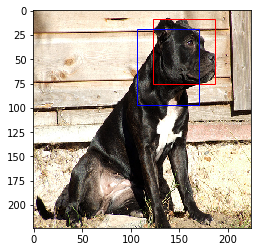

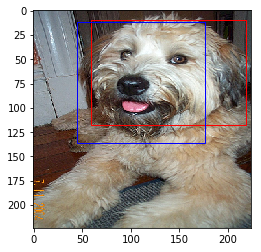

In [32]:
## 예측한 bounding box와 ground truth box를 image에 같이 표시
## 정답은 빨간색 box, 예측은 파란색 box
idx = 0
for val_data, val_gt in val_dataset:
    ## 정답 box 그리기
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    xmin = x[0].numpy() - w[0].numpy()/2.
    ymin = y[0].numpy() - h[0].numpy()/2.
    rect_x = int(xmin * img_size)
    rect_y = int(ymin * img_size)
    rect_w = int(w[0].numpy() * img_size)
    rect_h = int(h[0].numpy() * img_size)
    
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    
    ## 예측 box 그리기
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    pred_xmin = pred_x[idx*batch_size] - pred_w[idx*batch_size]/2.
    pred_ymin = pred_y[idx*batch_size] - pred_h[idx*batch_size]/2.
    pred_rect_x = int(pred_xmin * img_size)
    pred_rect_y = int(pred_ymin * img_size)
    pred_rect_w = int(pred_w[idx*batch_size] * img_size)
    pred_rect_h = int(pred_h[idx*batch_size] * img_size)
    
    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                         fill=False, color='blue')
    plt.axes().add_patch(pred_rect)
    
    ## image와 bbox 함께 출력
    plt.imshow(val_data[0])
    plt.show()
    idx += 1